Total words found: 165295
Unique words: 7531
Number of sequences: 55095
Vocabulary size: 7531
Training set shape: (33057, 10)
Validation set shape: (11019, 10)
Test set shape: (11019, 10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.0299 - loss: 7.1955 - val_accuracy: 0.0428 - val_loss: 6.3471
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.0429 - loss: 6.1675 - val_accuracy: 0.0469 - val_loss: 6.3250
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.0547 - loss: 6.0185 - val_accuracy: 0.0631 - val_loss: 6.2399
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.0681 - loss: 5.8437 - val_accuracy: 0.0785 - val_loss: 6.1390
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.0822 - loss: 5.6459 - val_accuracy: 0.0854 - val_loss: 6.0484
Epoch 6/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.0952 - loss: 5.4565 - val_accuracy: 0.0962 - val_loss: 6.0122
Epoch 7/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.1074 - loss: 5.3034 - val_accuracy: 0.0996 - val_loss: 5.9966
Epoch 8/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.1160 - loss: 5.1448 - 

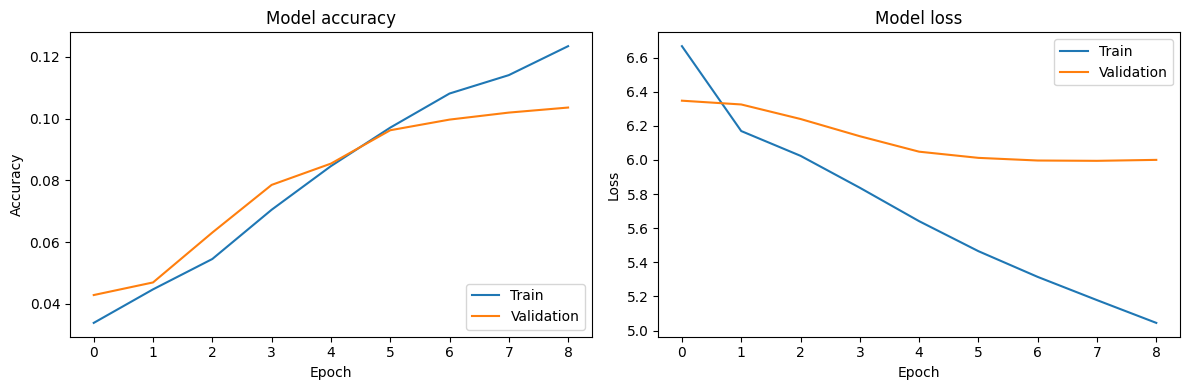


Evaluation Results:
--------------------------------------------------
Dataset        Loss           Accuracy       
--------------------------------------------------
Training       4.8226         0.1323         
Validation     6.0004         0.1035         
Test           6.0086         0.1062         
--------------------------------------------------

Accuracy is too low. To increase it, you could:
1. Decrease dropout rates (currently 0.4)
2. Increase LSTM units (currently 128)
3. Train for more epochs
4. Add more training data by decreasing the step size

Generating text with probabilities:
Seed sequence: 'she was the youngest of the two daughters of a'

Top 5 predictions for next word:
  little          0.0260 (2.60%)
  few             0.0154 (1.54%)
  very            0.0152 (1.52%)
  great           0.0138 (1.38%)
  thing           0.0132 (1.32%)

Top 5 predictions for next word:
  deal            0.0388 (3.88%)
  room            0.0141 (1.41%)
  days            0.0115 (1.15%)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import requests
import re

# Download Emma from Project Gutenberg
url = "https://www.gutenberg.org/files/158/158-0.txt"
response = requests.get(url)
text = response.text

# Basic preprocessing
# Remove the Project Gutenberg header and footer
start_idx = text.find("VOLUME I")
end_idx = text.find("End of the Project Gutenberg")
if start_idx != -1 and end_idx != -1:
    text = text[start_idx:end_idx].strip()
else:
    # If markers not found, just use the whole text
    print("Warning: Could not find exact markers, using full text")

# Split text into words
words = re.findall(r'\b\w+\b', text.lower())  # Convert to lowercase for better prediction
print(f"Total words found: {len(words)}")
print(f"Unique words: {len(set(words))}")

# Create sequences for word prediction
def create_sequences(words, seq_length):
    sequences = []
    next_words = []
    for i in range(0, len(words) - seq_length, 3):  # Step by 3 to reduce data size
        sequences.append(words[i:i + seq_length])
        next_words.append(words[i + seq_length])
    return sequences, next_words

# Parameters
seq_length = 10  # We'll use 10 words to predict the next word
step = 3  # Step size for creating sequences

# Create sequences
sequences, next_words = create_sequences(words, seq_length)
print(f"Number of sequences: {len(sequences)}")

# Create mapping from words to integers
unique_words = sorted(list(set(words)))
word_to_idx = {w: i for i, w in enumerate(unique_words)}
idx_to_word = {i: w for i, w in enumerate(unique_words)}
vocab_size = len(unique_words)
print(f"Vocabulary size: {vocab_size}")

# Convert sequences and next_words to numbers
X = np.zeros((len(sequences), seq_length), dtype=np.int32)
y = np.zeros(len(sequences), dtype=np.int32)

for i, sequence in enumerate(sequences):
    for t, word in enumerate(sequence):
        X[i, t] = word_to_idx[word]
    y[i] = word_to_idx[next_words[i]]

# Convert y to one-hot encoding
y_onehot = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

# Split the data: 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_onehot, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Build the LSTM model
embedding_dim = 100  # Dimension of the embedding space
lstm_units = 256    # Number of LSTM units

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=seq_length),
    LSTM(lstm_units, dropout=0.4, recurrent_dropout=0.4),  # High dropout to target ~50% accuracy
    Dense(vocab_size, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print model summary


# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    min_delta=0.01,
    mode='max',
    verbose=1
)

# Train the model - limiting to 10 epochs for Colab free tier
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Evaluate on all datasets
def evaluate_and_report(model, datasets, names):
    print("\nEvaluation Results:")
    print("-" * 50)
    print(f"{'Dataset':<15}{'Loss':<15}{'Accuracy':<15}")
    print("-" * 50)

    for (X, y), name in zip(datasets, names):
        loss, acc = model.evaluate(X, y, verbose=0)
        print(f"{name:<15}{loss:<15.4f}{acc:<15.4f}")
    print("-" * 50)

# Evaluate on all datasets
evaluate_and_report(
    model,
    [(X_train, y_train), (X_val, y_val), (X_test, y_test)],
    ["Training", "Validation", "Test"]
)

# If accuracy is still not close to 50%, here's how to adjust it:
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
if test_acc > 0.55:
    print("\nAccuracy is too high. To reduce it, you could:")
    print("1. Increase dropout rates (currently 0.4)")
    print("2. Reduce LSTM units (currently 128)")
    print("3. Train for fewer epochs")
    print("4. Add L2 regularization to the layers")
elif test_acc < 0.45:
    print("\nAccuracy is too low. To increase it, you could:")
    print("1. Decrease dropout rates (currently 0.4)")
    print("2. Increase LSTM units (currently 128)")
    print("3. Train for more epochs")
    print("4. Add more training data by decreasing the step size")
else:
    print("\nThe accuracy is close to the target of 50%")

# Generate text with word predictions and probabilities
def generate_text_with_probs(model, seed_sequence, next_words=10, top_n=5):
    current_sequence = seed_sequence.copy()
    generated_text = " ".join(seed_sequence)

    print(f"Seed sequence: '{' '.join(seed_sequence)}'")

    for _ in range(next_words):
        # Convert the current sequence to input format
        x_pred = np.zeros((1, seq_length))
        for t, word in enumerate(current_sequence):
            if word in word_to_idx:
                x_pred[0, t] = word_to_idx[word]

        # Get prediction probabilities
        preds = model.predict(x_pred, verbose=0)[0]

        # Get indices of top N predictions
        top_indices = preds.argsort()[-top_n:][::-1]

        # Print top predictions with probabilities
        print(f"\nTop {top_n} predictions for next word:")
        for idx in top_indices:
            word = idx_to_word[idx]
            prob = preds[idx]
            print(f"  {word:<15} {prob:.4f} ({prob:.2%})")

        # Get the index of the next word (top prediction)
        next_index = top_indices[0]
        next_word = idx_to_word[next_index]

        # Append the next word to the generated text
        generated_text += " " + next_word

        # Update the current sequence
        current_sequence = current_sequence[1:] + [next_word]

    return generated_text

# Test with some seed sequence from Emma
seed_words = ["she", "was", "the", "youngest", "of", "the", "two", "daughters", "of", "a"]
print("\nGenerating text with probabilities:")
generated_text = generate_text_with_probs(model, seed_words, next_words=10, top_n=5)
print("\nFinal generated text:")
print(generated_text)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 10, 100)             │         753,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 256)                 │         365,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7531)                │       1,935,467 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,162,407 (34.95 MB)

 Trainable params: 3,054,135 (11.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,108,272 (23.30 MB)

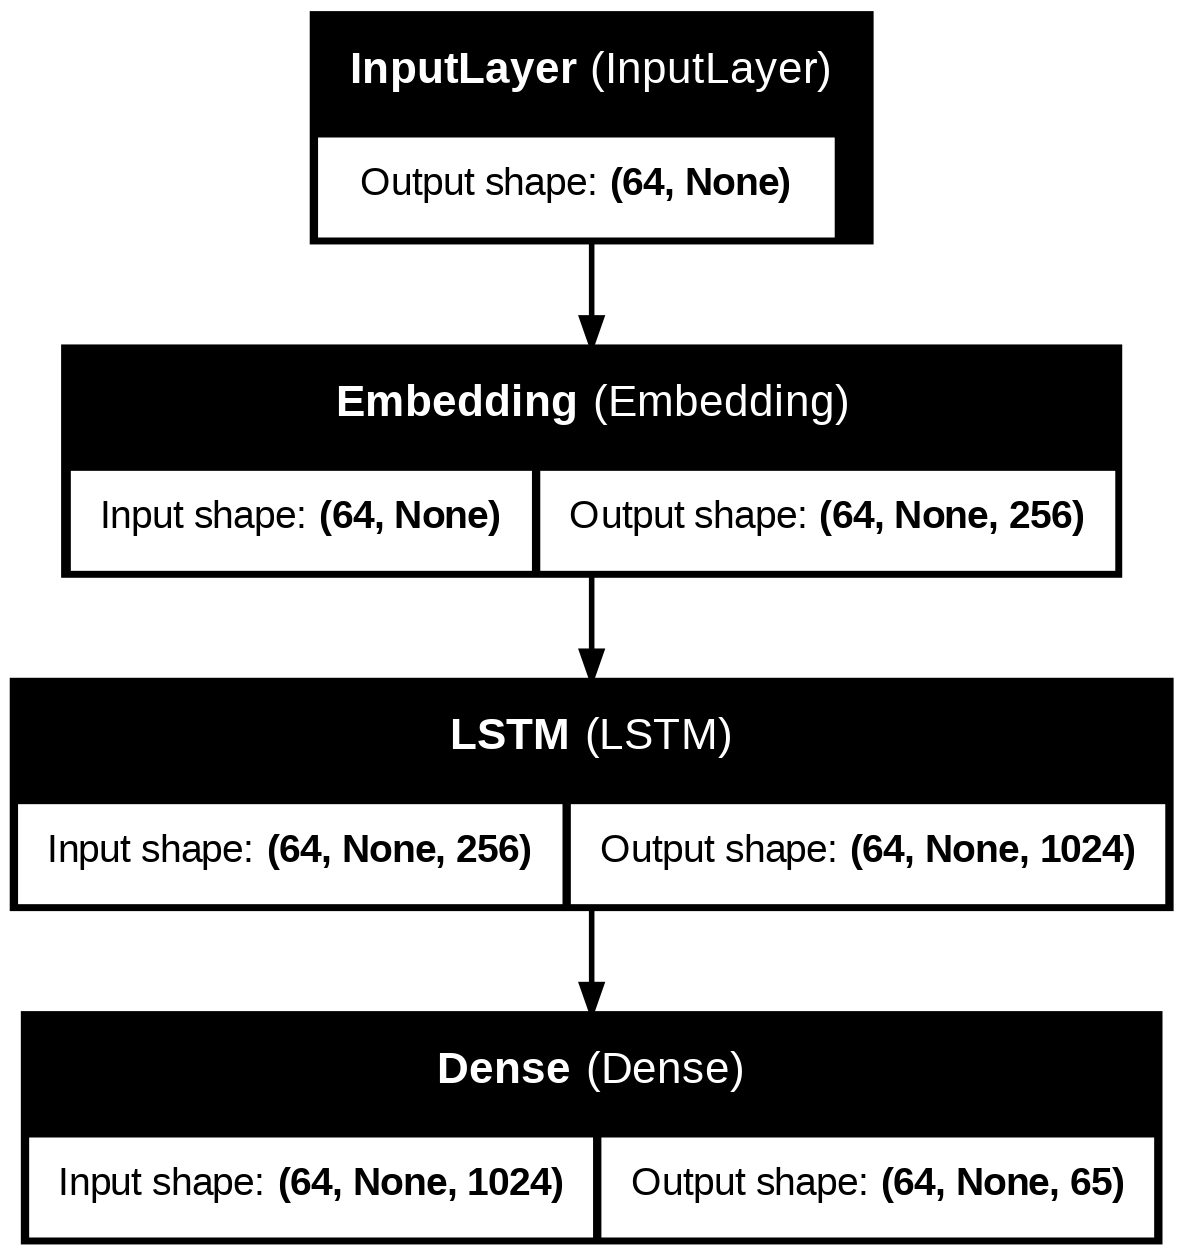

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.utils import plot_model

# Define model architecture
input_layer = Input(shape=(None,), batch_size=64, name="InputLayer")
embedding_layer = Embedding(input_dim=10000, output_dim=256, name="Embedding")(input_layer)
lstm_layer = LSTM(1024, return_sequences=True, name="LSTM")(embedding_layer)
output_layer = Dense(65, activation="softmax", name="Dense")(lstm_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Generate a flowchart
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)


In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)              │ (64, None)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Embedding (Embedding)                │ (64, None, 256)             │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM (LSTM)                          │ (64, None, 1024)            │       5,246,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense (Dense)                        │ (64, None, 65)              │          66,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,873,601 (30.04 MB)

 Trainable params: 7,873,601 (30.04 MB)

 Non-trainable params: 0 (0.00 B)